##### softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持 可导的性质。 
##### 为了完成这一目标，我们首先对每个未规范化的预测求幂，这样可以确保输出非负。 为了确保最终输出的概率值总和为1，我们再让每个求幂后的结果除以它们的总和。

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

##### 初始化模型参数

In [2]:
# 原始数据集中的每个样本都是28*28的图像。 本节将展平每个图像，把它们看作长度为784的向量
# 在softmax回归中，我们的输出与类别一样多。 因为我们的数据集有10个类别，所以网络输出维度为10。
#因此，权重将构成一个784*10的矩阵， 偏置将构成一个1*10的行向量
# 理论：d维度n个batch的q分类向量, X：n*d , W: d*q, b: 1*q

In [3]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

##### 定义softmax

In [4]:
# 如果X是一个形状为(2, 3)的张量，我们对列进行求和， 则结果将是一个具有形状(3,)的向量
# dim 指定的是要“消掉”的那个维度（dimension）。
# 比如, 你dim = 0, 说明你要消除的dimention=0,你要把行消除掉,也就是说我要上下压扁这个矩阵,3,2->(2,)
# dim = 1,如果keepdim = True : 3,2->3,1 ; keepdim = False : 3,2->(3,)
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [5]:
# 实现softmax一般三个步骤
# 1.对每个项求幂（使用exp）
# 2.对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；
# 3.将每一行除以其规范化常数，确保结果的和为1
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim = True)
    return X_exp / partition

In [6]:
# 实验softmax是否成功
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[ 0.3898,  1.3793, -1.4941,  0.6241,  0.0869],
         [-0.5391,  0.5479, -0.6158, -0.7160,  1.4326]]),
 tensor([[0.1711, 0.4602, 0.0260, 0.2163, 0.1264],
         [0.0774, 0.2296, 0.0717, 0.0649, 0.5563]]),
 tensor([1.0000, 1.0000]))

##### 注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。 矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点

In [7]:
# 下面的代码定义了输入如何通过网络映射到输出。 
# 注意，将数据传递到模型之前，我们使用reshape函数将每张原始图像展平为向量。

In [8]:
# X: batchsize*784 W: 784 * 10
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [9]:
# 下面，我们创建一个数据样本y_hat，其中包含2个样本在3个类别的预测概率， 以及它们对应的标签y。 
# 有了y，我们知道在第一个样本中，第一类是正确的预测； 而在第二个样本中，第三类是正确的预测。 
# 然后使用y作为y_hat中概率的索引， 我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率。
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y] # 同时对行和列进行索引
# 等价于y_hat[[0,1], y] = [ y_hat[0][ y[0] ],  y_hat[1][ y[1] ] ]

tensor([0.1000, 0.5000])

In [10]:
# 现在我们只需一行代码就可以实现交叉熵损失函数。
# y_hat[range(len(y_hat)),y] 等价于 y_hat[range(2), y], 等长列表的range,会按元素对齐
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [11]:
def accuracy(y_hat, y): #@save
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 比如 [0.1,0.8],[0.8,0.4] 我axis=1,把(2,2)->(2,1)
        # 也就是变成了[1][0]
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y # 比较预测与真实标签是否相等,需要转化为相同type
    return float(cmp.type(y.dtype).sum())   

In [12]:
accuracy(y_hat, y)/len(y) # return的是总的数值，得除以总的长度才能看出来准确率

0.5

In [13]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        # 优雅的写法，data是目前自己的值，args表示可以接受任意类型的参数，zip打包表示一一对应。
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
# 同样，对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。
def evaluate_accuracy(net, data_iter):  #@save
    if isinstance(net, torch.nn.Module): # isinstance来自 Python 本身，用来判断某个对象是不是某个类的实例
        net.eval() # 将模型设置为评估模式,因为只有module中才有eval所以要检查isinstance
    metric = Accumulator(2) # 正确预测数/预测总数
    with torch.no_grad(): # 关闭梯度
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel()) # y.numel返回张量中元素的中的数量
    return metric[0] / metric[1]

In [15]:
# 首先，我们定义一个函数来训练一个迭代周期。 
# 请注意，updater是更新模型参数的常用函数，它接受批量大小作为参数。 它可以是d2l.sgd函数，也可以是框架的内置优化函数。
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward() # 对 batchloss求均值可以防止batch越大,loss越大
            updater.step()
        else: 
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0]) # shape are like: [64,1,28,28]
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [16]:
# 在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类Animator， 它能够简化本书其余部分的代码
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l_torch.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l_torch.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [17]:
# 接下来我们实现一个训练函数， 它会在train_iter访问到的训练数据集上训练一个模型net。 
# 该训练函数将会运行多个迭代周期（由num_epochs指定）。 
# 在每个迭代周期结束时，利用test_iter访问到的测试数据集对模型进行评估。 我们将利用Animator类来可视化训练进度。
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [18]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

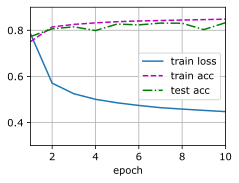

In [19]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

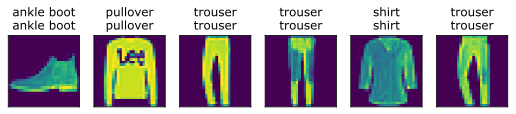

In [21]:
# 预测
def predict_ch3(net, test_iter, n=6):  #@save
    for X, y in test_iter:
        break # 只拿第一组X, y
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
predict_ch3(net, test_iter)   